# Example Fitting with ADCG

This example uses images from the 561 channel in position 4 of replicate 2, to be consistent with the companion packages.

In [ ]:
using Pkg
Pkg.add("Plots")
Pkg.add("FileIO")
Pkg.add("Images")
Pkg.add("CSV")
Pkg.add(url="https://github.com/CaiGroup/SeqFISH_ADCG.jl")

In [1]:
using Plots
using SeqFISH_ADCG
using FileIO
using Images
using CSV

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423
┌ Info: Precompiling SeqFISH_ADCG [43951575-4589-48f4-b0ab-ec671c641013]
└ @ Base loading.jl:1423
┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1423
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1423


Load example data

In [2]:
ro_img = load("../example_data/ro_preprocessed.png")
ro_img = reinterpret.(UInt16, channelview(ro_img));

┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1423


Set Parameters

In [3]:
sigma_lb = 0.87
sigma_ub = 1.22
tau = 2.0*10^12
final_loss_improvement = 1000.0
min_weight = 800.0
max_iters = 200
max_cd_iters = 20
threshold = 0.0;

For expediancy of the demonstration, we will choose a small example tile to run ADCG on

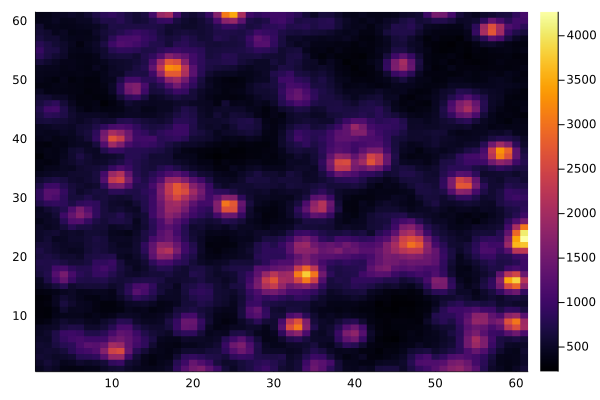

In [4]:
example_tile = ro_img[1020:1080, 1220:1280]
heatmap(example_tile)

Now we run ADCG on the tile sample tile

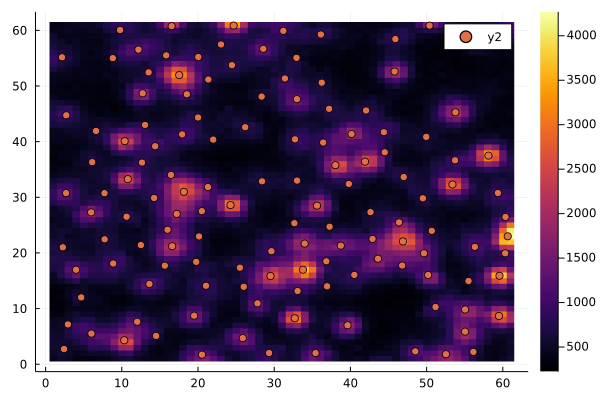

In [5]:
inputs = (example_tile, sigma_lb, sigma_ub, threshold, tau, final_loss_improvement, min_weight, max_iters, max_cd_iters)
ps = fit_tile(inputs)

heatmap(example_tile)
scatter!(ps[1,:], ps[2,:])

ADCG appears to pick up all of the dots. It may have a few extra, but it better to tune the parameters such that too many dots are picked up than too few because [SeqFISHSyndromeDecoding](https://github.com/CaiGroup/SeqFISHSyndromeDecoding) is very effective at discarding bad dots.

Running ADCG on a whole image requires breaking up the image into overlapping tiles, running ADCG on each tile, and piecing the tiles back together. All of the Cai Lab's microscopes use 2048X2048 cameras, so SeqFISH_ADCG comes with a special function, ```fit_2048x2048_img_tiles```, that breaks 2048 images up into tiles. (Warning: this function will take a few hours)

In [ ]:
points_with_duplicates = fit_2048x2048_img_tiles(ro_img, sigma_lb, sigma_ub, tau, final_loss_improvement, min_weight, max_iters, max_cd_iters, threshold);
first(points_with_duplicates, 5)

In [ ]:
println(first(points_with_duplicates, 5))

If you have images that are not of 2048x2048 pixels, you will need to use ```fit_img_tiles```, which ```fit_2048x2048_img_tiles``` wraps, and specify your own tile and overlap size. For example ```fit_2048x2048_img_tiles``` calls (again taking hours):

In [ ]:
tile_width = 64
tile_overlap = 6

points_with_duplicates2 = fit_img_tiles(ro_img, tile_width, tile_overlap, sigma_lb, sigma_ub, tau, final_loss_improvement, min_weight, max_iters, max_cd_iters, threshold)
first(points_with_duplicates2, 5)

In [ ]:
println(first(points_with_duplicates2, 5))

You will need to ensure that the width and height of your image is divisible by ```tile_width```.

The next step is that you will need to remove dots that are too close to each other. This removes duplicates that are in the overlapping regions of the tiles, or may have just been fit twice by ADCG

In [ ]:
min_allowed_separation=2.0
points = remove_duplicates(points_with_duplicates, ro_img, sigma_lb, sigma_ub, tau, threshold, min_allowed_separation)
first(points, 5)

In [ ]:
println(first(points, 5))

In [ ]:
CSV.write("example_fit.csv", points)